<a href="https://colab.research.google.com/github/Savith-02/notebooks/blob/main/rnn_intent_classifier/rnn_intent_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
def read_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            intent, sentence = line.strip().split(',')
            data.append((intent.strip(), sentence.strip()))
    return data

# Example usage
file_path = "data.txt"  # Replace with the path to your dataset file
dataset = read_dataset(file_path)
print(dataset[:10])

[('Intent', 'Example'), ('Greet', 'Hi'), ('Greet', 'Hello'), ('Greet', 'Hey there'), ('Greet', 'Good morning'), ('Greet', 'Howdy'), ('Greet', 'Hi there'), ('Greet', 'Hey'), ('Greet', 'Good afternoon'), ('Greet', 'Hello there')]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the dataset
training_data = dataset

# Define the vocabulary
all_chars = set(''.join([sentence for intent, sentence in training_data]))
char_to_index = {char: i for i, char in enumerate(all_chars)}
index_to_char = {i: char for char, i in char_to_index.items()}
num_chars = len(all_chars)

all_intents = set(intent for intent, _ in training_data)
intent_to_index = {intent: i for i, intent in enumerate(all_intents)}
index_to_intent = {i: intent for intent, i in intent_to_index.items()}
num_intents = len(all_intents)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert sentences to tensors
def sentence_to_tensor(sentence):
    tensor = torch.zeros(len(sentence), 1, num_chars).to(device)
    for i, char in enumerate(sentence):
        tensor[i][0][char_to_index[char]] = 1
    return tensor

# Convert intents to tensors
def intent_to_tensor(intent):
    return torch.tensor([intent_to_index[intent]], dtype=torch.long).to(device)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        hidden = self.init_hidden()
        output, _ = self.rnn(input, hidden)
        output = self.fc(output[-1])
        output = self.softmax(output)
        return output

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

In [ ]:
optim.lr_scheduler.ExponentialLR
# import torch.optim as optim


Epoch 10/100, Loss: 655.1257840394974
Epoch 20/100, Loss: 560.4902209937572
Epoch 30/100, Loss: 457.06454165279865
Epoch 40/100, Loss: 398.92601415514946
Epoch 50/100, Loss: 376.9429252743721
Epoch 60/100, Loss: 369.1949158832431
Epoch 70/100, Loss: 366.4886176735163
Epoch 80/100, Loss: 365.5448329746723
Epoch 90/100, Loss: 365.2160677611828
Epoch 100/100, Loss: 365.101518638432


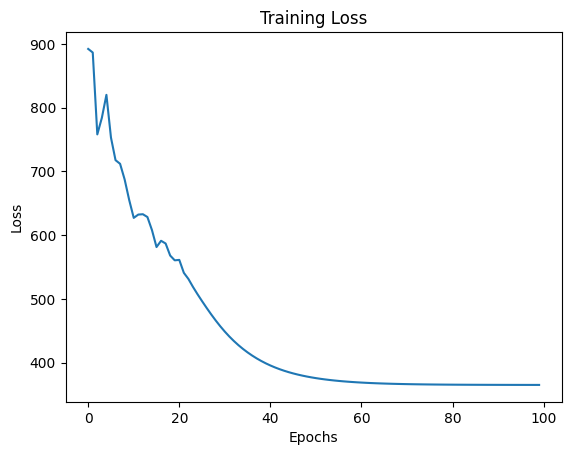

In [5]:
# Define hyperparameters
hidden_size = 128
learning_rate = 0.001
epochs = 100

# Initialize the model
model = RNN(num_chars, hidden_size, num_intents)
model.to(device)

loss_function = nn.NLLLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training loop with loss plotting
losses = []
for epoch in range(epochs):
    total_loss = 0
    for intent, sentence in training_data:
        model.zero_grad()
        intent_tensor = intent_to_tensor(intent)
        sentence_tensor = sentence_to_tensor(sentence)
        output = model(sentence_tensor)
        loss = loss_function(output, intent_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    losses.append(total_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

# Plot the loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Epoch 10/100, Loss: 776.9968077144586
Epoch 20/100, Loss: 687.7193780839443
Epoch 30/100, Loss: 614.765313565731
Epoch 40/100, Loss: 649.5537842418998
Epoch 50/100, Loss: 602.286672540009
Epoch 60/100, Loss: 698.5288188485429
Epoch 70/100, Loss: 611.2944913068786
Epoch 80/100, Loss: 558.7213475285098
Epoch 90/100, Loss: 500.797096863389
Epoch 100/100, Loss: 536.7669018181041


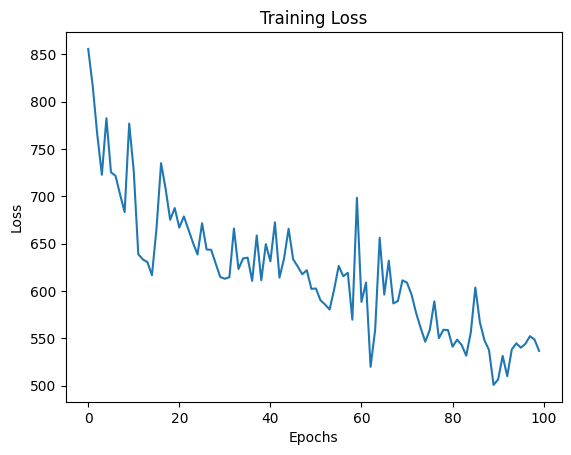

In [10]:
# Define hyperparameters
hidden_size = 128
learning_rate = 0.001
epochs = 100

# Initialize the model
model = RNN(num_chars, hidden_size, num_intents)
model.to(device)

loss_function = nn.NLLLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Training loop with loss plotting
losses = []
for epoch in range(epochs):
    total_loss = 0
    for intent, sentence in training_data:
        model.zero_grad()
        intent_tensor = intent_to_tensor(intent)
        sentence_tensor = sentence_to_tensor(sentence)
        output = model(sentence_tensor)
        loss = loss_function(output, intent_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # scheduler.step()
    losses.append(total_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

# Plot the loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [11]:
# Test the model
def predict_intent(sentence):
    with torch.no_grad():
        output = model(sentence_to_tensor(sentence))
        _, predicted_index = torch.max(output, 1)
        predicted_intent = index_to_intent[predicted_index.item()]
        return predicted_intent

# Example usage
test_sentence = "byeee next time"
print("Predicted intent:", predict_intent(test_sentence))

Predicted intent: Navigation


In [9]:
# all_intents

{'Complaint',
 'Confirmation',
 'Farewell',
 'Feedback',
 'Greet',
 'Inquiry',
 'Intent',
 'Navigation',
 'Request'}

In [ ]:
# char_to_index.items()

dict_items([('l', 0), ('R', 1), ('q', 2), ('m', 3), ('B', 4), ('U', 5), ('C', 6), ('w', 7), ('e', 8), ('o', 9), ('h', 10), ('p', 11), ('T', 12), ('v', 13), ('L', 14), ('F', 15), ('n', 16), ('S', 17), ('P', 18), ('-', 19), ('b', 20), ('i', 21), ('G', 22), ('2', 23), ('.', 24), ('u', 25), ('g', 26), ('j', 27), ('c', 28), ('E', 29), ('W', 30), ('x', 31), ('N', 32), ('f', 33), ('O', 34), ('r', 35), ('z', 36), ('a', 37), ('t', 38), ('k', 39), ('?', 40), (' ', 41), ('y', 42), ('Y', 43), ('I', 44), ('s', 45), ('7', 46), ('H', 47), ('A', 48), ('"', 49), ("'", 50), ('d', 51), ('M', 52), ('!', 53)])